In [1]:
#########
import torch
# import argparse
import Huber_PM.robust_mean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import diffprivlib as dpl
import Other_Mean_Algs as OMA
import P_Trimed_Mean as PTA
from tqdm import tqdm
import itertools
import pickle
import os
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
df=pd.read_csv('cleaned_for_dp.csv')
df['lscore']=np.log(df['score'])
df.head()

,week,weeks4,datesubmitted,season,id,wave,variant,mitigation,score,depression,...,occupation4,prov,report,reports,winter,over_40,over_50,time,num_date,lscore
0,2021-03-21,2021-03-28,2021-03-27,2,786,3,3,1,25,15,...,1,2,1,7,False,True,False,0.0,18714,3.218876
1,2021-03-28,2021-03-28,2021-03-28,2,636,3,3,1,26,19,...,2,1,1,1,False,False,False,0.0,18714,3.258097
2,2021-03-28,2021-03-28,2021-03-28,2,709,3,3,1,13,7,...,4,1,1,1,False,False,False,0.0,18714,2.564949
3,2021-03-28,2021-03-28,2021-03-28,2,746,3,3,1,19,12,...,1,1,1,6,False,True,True,0.0,18714,2.944439
4,2021-03-28,2021-03-28,2021-03-28,2,787,3,3,1,18,10,...,1,2,1,5,False,True,False,0.0,18714,2.890372


In [3]:
# full_model=lmer(log(score)~time+winter+mitigation+(1|id),data=df)
# Run LMER
# Non-private case
mdt = smf.mixedlm("lscore~time+winter+mitigation", df, groups=df["id"], re_formula="~1")
true_model = mdt.fit(method=["lbfgs"])
# print(mdf.summary())
print(list(true_model.fe_params))
print(true_model.cov_re.iloc[0,0])  # covariance matrix of random effects
print(true_model.scale)
true_values=np.array(list(true_model.fe_params)+[true_model.cov_re.iloc[0,0],true_model.scale])

[2.90538067076401, 0.02452135889783584, -0.12988942812340037, 0.05004374524745771]
0.0856148192890804
0.04057234836739159


In [4]:
# Let's get the Huber mean working
n=50
rho=1
x = np.random.normal(size=(n,1))
T = int(np.log(n))
model = Huber_PM.robust_mean.m_est(x)
# 2rho = epsilon^2 => epsilon=sqrt(2rho)
priv_mean, _, _ = model.noisy_adaptive_huber(epsilon = np.sqrt(2*rho), T = T)
priv_mean

array([-0.07740074])

In [40]:
# Let's write some subsample and aggregate code
# size of groups
k=150


# split the data into k sub samples
ids=df['id'].unique()
print(ids.size)
np.random.shuffle(ids) 
id_groups=[ids[i:i+k] for i in range(0,len(ids)-k+1,k)]
dfs=[df[df['id'].isin(cid)] for cid in id_groups ]

all_ests=[]
for sdf in dfs:
    md = smf.mixedlm("lscore~time+winter+mitigation", sdf, groups=sdf["id"], re_formula="~1")
    try:
        mdf = md.fit(method=["lbfgs"])
        res=list(mdf.fe_params)+[mdf.cov_re.iloc[0,0],mdf.scale]
        all_ests.append(res)
    except:
        print("Singular!")
    # print(mdf.summary())
all_ests=[np.array(x) for x in all_ests]
all_est=np.vstack(all_ests)
all_ests=np.array(all_ests)
all_ests.shape

2327


(15, 6)

In [6]:
X=all_ests

# Privacy level
rho=1
d=X.shape[1]
n=X.shape[0]
sqrtd=np.sqrt(d)

# Algorithm parameters
u=40*sqrtd
radius=2*u
ell=-u
beta=1.001
Tt = int(np.log(n))
C=10
eta=0
rho2=rho/d

# We now have the code to estimate the mean of the parameter vector privately:
# One-dimensional mean
tm=np.zeros(d)
for j in range(d):
    tm[j]=PTA.private_tm_zCDP_mod_1(X[:,j], ell,u,rho2/4,rho2/4,rho2/2,beta=beta,constant=C,eta=eta)
# PRIME
try:
    prime=OMA.PRIME(np.sqrt(2*rho), 0.01, X.copy(), 0.125, radius)
except:
    prime=np.nan
# Huber
model = Huber_PM.robust_mean.m_est(X)
# 2rho = epsilon^2 => epsilon=sqrt(2rho)
priv_mean, _, _ = model.noisy_adaptive_huber(epsilon = np.sqrt(2*rho), T = Tt)
# Coinpress
try:
    CoinPress=OMA.COINPRESS(torch.from_numpy(X).float() ,n,d,rho,torch.zeros(d),radius,50 * sqrtd)[0].numpy()
except:
    CoinPress=np.nan

# OMA.COINPRESS(torch.from_numpy(X),n,d,rho,torch.zeros(d),radius,50 * sqrtd)[0].numpy()
print('Output: ')

print(np.abs(tm-true_values).sum())
print(np.abs(prime-true_values).sum())
print(np.abs(priv_mean-true_values).sum())
print(np.abs(CoinPress-true_values).sum())

Output: 
37.20281573050669
2639.828820176145
3.232748432817463
591033.4217855477


In [7]:
######## Pure DP 



# Now do the above 50 times, for many different k - then make a table 
def one_run(u,eps=10,k=100,seed=np.nan):
    # Set the seed
    np.random.seed(seed=seed) 
    torch.manual_seed(seed) 
    # split the data into k sub samples
    ids=df['id'].unique()
    np.random.shuffle(ids) 
    id_groups=[ids[i:i+k] for i in range(0,len(ids)-k+1,k)]
    dfs=[df[df['id'].isin(cid)] for cid in id_groups ]

    all_ests=[]
    for sdf in dfs:
        md = smf.mixedlm("lscore~time+winter+mitigation", sdf, groups=sdf["id"], re_formula="~1")
        try:
            mdf = md.fit(method=["lbfgs"])
            res=list(mdf.fe_params)+[mdf.cov_re.iloc[0,0],mdf.scale]
            all_ests.append(res)
        except:
            # print("Singular!")
            a=''
        # print(mdf.summary())
    all_ests=[np.array(x) for x in all_ests]
    all_ests=np.vstack(all_ests)
    all_ests=np.array(all_ests)
    all_ests.shape
    X=all_ests
    # Privacy level
    d=X.shape[1]
    n=X.shape[0]
    sqrtd=np.sqrt(d)

# Algorithm parameters
    u=u*sqrtd
    ell=-u
    beta=1.001
    C=1
    eta=0


    # We now have the code to estimate the mean of the parameter vector privately:
    # One-dimensional mean
    try:
        tm=np.zeros(d)
        for j in range(d):
            tm[j]=PTA.private_tm_zCDP_mod_1(X[:,j].copy(), ell,u,eps/(4*d),eps/(4*d),eps/(2*d),beta=beta,constant=C,eta=eta)
        tm=np.abs(tm-true_values).sum()
    except:
        tm=np.nan
    try:
        wwm=np.zeros(d)
        for j in range(d):
            wwm[j]=OMA.WWM(X[:,j].copy(),eps/d,ell,u)
        wwm=np.abs(wwm-true_values).sum()
    except:
        wwm=np.nan
    try:
        vm=np.zeros(d)
        for j in range(d):
            vm[j]=OMA.clipped_mean(X[:,j].copy(), ell,u,eps/(d))
        vm=np.abs(vm-true_values).sum()
    except:
        vm=np.nan
    return np.array([tm,vm,wwm])
    
import warnings; warnings.simplefilter('ignore')



ks=np.arange(10,110,10)
# us=np.arange(10,100,10)
num_runs=50
# [1,10,100]
us=[40]
if True:
    for eps in [1]:
        for u in us:
            file_name='new_PDP_u_'+str(u)+'_rho_'+str(rho)+'diff_k_lmm_table.pkl'
            output=[]
            if not os.path.exists(file_name):
                for k in ks:
                    if k>min(ks):
                        output.append(output2)
                    output2=[]
                    for run in range(num_runs):
                    # Now set the seed 
                        output2.append(one_run(u=u,eps=eps,k=k,seed=run))
                    # if (run % 10) ==0:
                    #     print(run/num_runs)
                    print('complete k = ',k,' u ',u, ' rho ', rho)
                output.append(output2)
                with open(file_name, 'wb') as file:
                    pickle.dump(output, file)
    # else:
    #     with open(file_name, 'rb') as file:
    #         output = pickle.load(file)

complete k =  10  u  40  rho  1
complete k =  20  u  40  rho  1
complete k =  30  u  40  rho  1
complete k =  40  u  40  rho  1
complete k =  50  u  40  rho  1
complete k =  60  u  40  rho  1
complete k =  70  u  40  rho  1
complete k =  80  u  40  rho  1
complete k =  90  u  40  rho  1
complete k =  100  u  40  rho  1


In [8]:
# Process results PDP
ks=np.arange(10,110,10)
us=np.arange(10,100,10)
us=[40]
dfs=[]
# for rho in [1,10,100]:
for eps in [1]:
    for u in us:
        file_name='new_PDP_u_'+str(u)+'_rho_'+str(rho)+'diff_k_lmm_table.pkl'
        try:
            with open(file_name, 'rb') as file:
                output = pickle.load(file)
            # print(np.isnan(np.array( output)).sum(axis=1).mean(axis=0))
            output3=np.nanmean(np.array( output),axis=1)
            error_df=pd.DataFrame(data=output3)
            # print(error_df.head())
            error_df.columns=['Proposed Mean','Vanilla Mean','WW Mean']
            error_df['k']=ks
            error_df['u']=u
            error_df['eps']=eps
            melted=pd.melt(error_df,id_vars=['k','u','eps'],
                        value_vars=['Proposed Mean','Vanilla Mean','WW Mean'],
                        var_name='Estimator', value_name='MAE')
            # melted.head()
            melted['lMAE']=np.log(melted['MAE'])
            dfs.append(melted)
        except:
            ''
dfs
overall=pd.concat(dfs,axis=0)


overall.head()
                

,k,u,eps,Estimator,MAE,lMAE
0,10,40,1,Proposed Mean,0.493257,-0.706725
1,20,40,1,Proposed Mean,0.267831,-1.317398
2,30,40,1,Proposed Mean,0.226199,-1.486339
3,40,40,1,Proposed Mean,0.234818,-1.448946
4,50,40,1,Proposed Mean,0.385349,-0.953607


\begin{tabular}{lrr}
\toprule
Estimator &  Proposed Mean &  WW Mean \\
k   &                &          \\
\midrule
10  &          0.493 & 2152.134 \\
20  &          0.268 & 3376.355 \\
30  &          0.226 & 4062.483 \\
40  &          0.235 & 4214.284 \\
50  &          0.385 & 4835.852 \\
60  &          5.822 & 5244.282 \\
70  &         23.988 & 4875.672 \\
80  &         45.934 & 5606.984 \\
90  &         72.352 & 6624.289 \\
100 &         88.130 & 6475.178 \\
\bottomrule
\end{tabular}



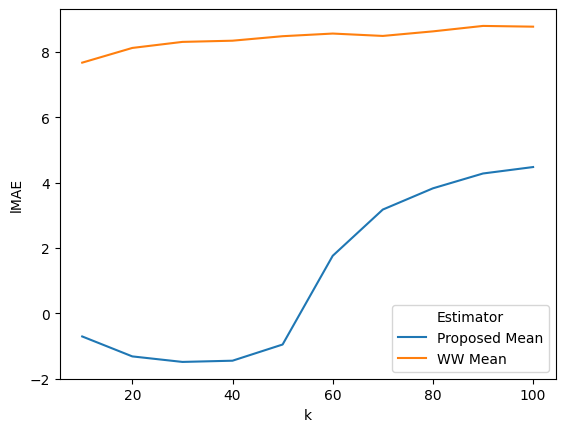

In [9]:
# Plot and print results PDP
sns.lineplot(data=overall[overall['Estimator']!="Vanilla Mean"],x='k',y='lMAE',hue='Estimator')

# np.repeat(ks, [50 for x in ks])

# plt.plot()
error_df2 = overall[overall['Estimator']!="Vanilla Mean"]
error_df4=pd.pivot_table(error_df2,columns='Estimator',values='MAE',index='k')
new_df_pt2=error_df4.round(4)
latex_table =new_df_pt2.to_latex( float_format="%.3f")
print(latex_table)




# N=len(df['id'].unique())
# N
# N/25

In [10]:
# zCDP results 


# Now do the above 50 times, for many different k - then make a table 
def one_run(u,rho=10,k=100,seed=np.nan):
    # Set the seed
    np.random.seed(seed=seed) 
    torch.manual_seed(seed) 
    # split the data into k sub samples
    ids=df['id'].unique()
    np.random.shuffle(ids) 
    id_groups=[ids[i:i+k] for i in range(0,len(ids)-k+1,k)]
    dfs=[df[df['id'].isin(cid)] for cid in id_groups ]

    all_ests=[]
    for sdf in dfs:
        md = smf.mixedlm("lscore~time+winter+mitigation", sdf, groups=sdf["id"], re_formula="~1")
        try:
            mdf = md.fit(method=["lbfgs"])
            res=list(mdf.fe_params)+[mdf.cov_re.iloc[0,0],mdf.scale]
            all_ests.append(res)
        except:
            # print("Singular!")
            a=''
        # print(mdf.summary())
    all_ests=[np.array(x) for x in all_ests]
    all_ests=np.vstack(all_ests)
    all_ests=np.array(all_ests)
    all_ests.shape
    X=all_ests
    # Privacy level
    d=X.shape[1]
    n=X.shape[0]
    sqrtd=np.sqrt(d)

# Algorithm parameters
    u=u*sqrtd
    radius=2*u
    ell=-u
    beta=1.001
    Tt = int(np.log(n))
    C=1
    eta=0
    rho=1
    rho2=rho/d

    # We now have the code to estimate the mean of the parameter vector privately:
    # One-dimensional mean
    try:
        tm=np.zeros(d)
        for j in range(d):
            tm[j]=PTA.private_tm_zCDP_mod_1(X[:,j].copy(), ell,u,rho2/4,rho2/4,rho2/2,beta=beta,constant=C,eta=eta)
        tm=np.abs(tm-true_values).sum()
    except:
        tm=np.nan
    try:
        vm=np.zeros(d)
        for j in range(d):
            vm[j]=OMA.clipped_mean(X[:,j].copy(), ell,u,rho2)
        vm=np.abs(vm-true_values).sum()
    except:
        vm=np.nan
    # PRIME
    try:
        # (epsilon, delta, X, alpha, R,seed=np.nan)
        prime=OMA.PRIME(np.sqrt(2*rho), 0.01, X.copy(), 0.125, radius)
        prime=np.abs(prime-true_values).sum()
    except:
        prime=np.nan
    # 2rho = epsilon^2 => epsilon=sqrt(2rho)
    try:
        # Huber
        model = Huber_PM.robust_mean.m_est(X.copy())
        priv_mean, _, _ = model.noisy_adaptive_huber(epsilon = np.sqrt(2*rho), T = Tt)
        priv_mean=np.abs(priv_mean-true_values).sum()
    except:
        priv_mean=np.nan
    # Coinpress
    try:
        CoinPress=OMA.COINPRESS(torch.from_numpy(X.copy()).float() ,n,d,rho,torch.zeros(d),radius,50 * sqrtd)[0].numpy()    
        CoinPress=np.abs(CoinPress-true_values).sum()
    except:
        CoinPress=np.nan
    # OMA.COINPRESS(torch.from_numpy(X),n,d,rho,torch.zeros(d),radius,50 * sqrtd)[0].numpy()
    # print('Output: ')
    return np.array([tm,vm,prime,priv_mean,CoinPress])
    
import warnings; warnings.simplefilter('ignore')



ks=np.arange(10,110,10)
# us=np.arange(10,100,10)
num_runs=50
# [1,10,100]
us=[40]
if True:
    for rho in [1]:
        for u in us:
            file_name='new_u_'+str(u)+'_rho_'+str(rho)+'diff_k_lmm_table.pkl'
            output=[]
            if not os.path.exists(file_name):
                for k in ks:
                    if k>min(ks):
                        output.append(output2)
                    output2=[]
                    for run in range(num_runs):
                    # Now set the seed 
                        output2.append(one_run(u=u,rho=rho,k=k,seed=run))
                    # if (run % 10) ==0:
                    #     print(run/num_runs)
                    print('complete k = ',k,' u ',u, ' rho ', rho)
                output.append(output2)
                with open(file_name, 'wb') as file:
                    pickle.dump(output, file)
    # else:
    #     with open(file_name, 'rb') as file:
    #         output = pickle.load(file)

complete k =  10  u  40  rho  1
complete k =  20  u  40  rho  1
complete k =  30  u  40  rho  1
complete k =  40  u  40  rho  1
complete k =  50  u  40  rho  1
complete k =  60  u  40  rho  1
complete k =  70  u  40  rho  1
complete k =  80  u  40  rho  1
complete k =  90  u  40  rho  1
complete k =  100  u  40  rho  1


In [12]:
ks=np.arange(10,110,10)
us=np.arange(10,100,10)
us=[40]
dfs=[]
# for rho in [1,10,100]:
for rho in [1]:
    for u in us:
        file_name='new_u_'+str(u)+'_rho_'+str(rho)+'diff_k_lmm_table.pkl'
        try:
            with open(file_name, 'rb') as file:
                output = pickle.load(file)
            # print(np.isnan(np.array( output)).sum(axis=1).mean(axis=0))
            output3=np.nanmean(np.array( output),axis=1)
            error_df=pd.DataFrame(data=output3)
            # print(error_df.head())
            error_df.columns=['Trimmed Mean','Vanilla Mean','PRIME','Huber','Coinpress']
            error_df['k']=ks
            error_df['u']=u
            error_df['rho']=rho
            melted=pd.melt(error_df,id_vars=['k','u','rho'],
                        value_vars=['Trimmed Mean','Vanilla Mean','PRIME','Huber','Coinpress'],
                        var_name='Estimator', value_name='MAE')
            # melted.head()
            melted['lMAE']=np.log(melted['MAE'])
            dfs.append(melted)
        except:
            ''
dfs
overall=pd.concat(dfs,axis=0)


overall.head()
                

,k,u,rho,Estimator,MAE,lMAE
0,10,40,1,Trimmed Mean,0.493257,-0.706725
1,20,40,1,Trimmed Mean,0.267831,-1.317398
2,30,40,1,Trimmed Mean,0.226199,-1.486339
3,40,40,1,Trimmed Mean,0.234818,-1.448946
4,50,40,1,Trimmed Mean,0.385349,-0.953607


<Axes: xlabel='k', ylabel='lMAE'>

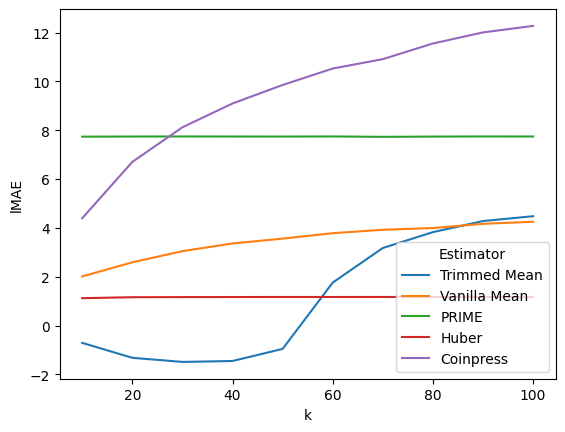

In [13]:
sns.lineplot(data=overall,x='k',y='lMAE',hue='Estimator')

\begin{tabular}{rrrrrr}
\toprule
  k &  Trimmed Mean &  Vanilla Mean &    PRIME &  Huber &  Coinpress \\
\midrule
 10 &         0.493 &         7.484 & 2289.532 &  3.075 &     81.140 \\
 20 &         0.268 &        13.358 & 2302.300 &  3.200 &    813.758 \\
 30 &         0.226 &        21.084 & 2307.890 &  3.216 &   3362.229 \\
 40 &         0.235 &        28.901 & 2302.797 &  3.224 &   8906.546 \\
 50 &         0.385 &        35.220 & 2299.656 &  3.229 &  18996.504 \\
 60 &         5.822 &        44.042 & 2308.754 &  3.229 &  37248.857 \\
 70 &        23.988 &        50.617 & 2273.696 &  3.231 &  54751.698 \\
 80 &        45.934 &        54.369 & 2296.854 &  3.232 & 103898.736 \\
 90 &        72.352 &        64.545 & 2309.577 &  3.233 & 163547.002 \\
100 &        88.130 &        70.247 & 2303.637 &  3.232 & 213275.071 \\
\bottomrule
\end{tabular}



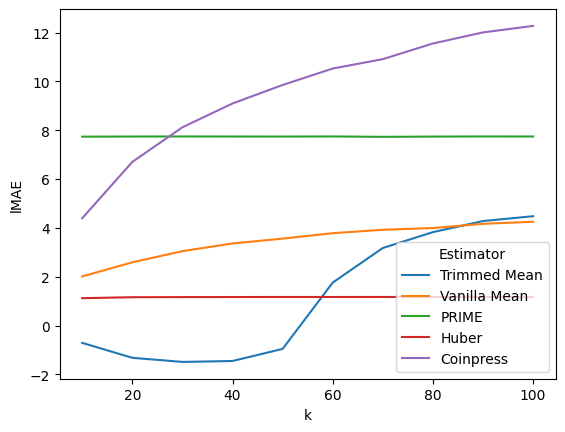

In [15]:
output3=np.nanmean(np.array( output),axis=1)
output3
error_df=pd.DataFrame(data=output3)
# print(error_df.head())
error_df.columns=['Trimmed Mean','Vanilla Mean','PRIME','Huber','Coinpress']
error_df['k']=ks
melted=pd.melt(error_df,id_vars='k',
               value_vars=['Trimmed Mean','Vanilla Mean','PRIME','Huber','Coinpress'],
               var_name='Estimator', value_name='MAE')
melted.head()
melted['lMAE']=np.log(melted['MAE'])
sns.lineplot(data=melted,x='k',y='lMAE',hue='Estimator')
# np.repeat(ks, [50 for x in ks])
error_df
# plt.plot()
error_df2 = error_df[['k','Trimmed Mean','Vanilla Mean','PRIME','Huber','Coinpress']]
new_df_pt2=error_df2.round(4)
latex_table =new_df_pt2.to_latex( index=False,float_format="%.3f")
print(latex_table)

# N=len(df['id'].unique())
# N
# N/25

In [16]:



# # Now do the above 50 times, for many different k - then make a table 
# def one_run(rho=10,k=100,seed=np.nan):
#     # Set the seed
#     np.random.seed(seed=seed) 
#     torch.manual_seed(seed) 
#     # split the data into k sub samples
#     ids=df['id'].unique()
#     np.random.shuffle(ids) 
#     id_groups=[ids[i:i+k] for i in range(0,len(ids)-k+1,k)]
#     dfs=[df[df['id'].isin(cid)] for cid in id_groups ]

#     all_ests=[]
#     for sdf in dfs:
#         md = smf.mixedlm("lscore~time+winter+mitigation", sdf, groups=sdf["id"], re_formula="~1")
#         try:
#             mdf = md.fit(method=["lbfgs"])
#             res=list(mdf.fe_params)+[mdf.cov_re.iloc[0,0],mdf.scale]
#             all_ests.append(res)
#         except:
#             # print("Singular!")
#             a=''
#         # print(mdf.summary())
#     all_ests=[np.array(x) for x in all_ests]
#     all_ests=np.vstack(all_ests)
#     all_ests=np.array(all_ests)
#     all_ests.shape
#     X=all_ests
#     # Privacy level
#     d=X.shape[1]
#     n=X.shape[0]
#     sqrtd=np.sqrt(d)

# # Algorithm parameters
#     u=40*sqrtd
#     radius=2*u
#     ell=-40*sqrtd
#     beta=1.001
#     Tt = int(np.log(n))
#     C=10
#     eta=0
#     rho2=rho/d

#     # We now have the code to estimate the mean of the parameter vector privately:
#     # One-dimensional mean
#     try:
#         tm=np.zeros(d)
#         for j in range(d):
#             tm[j]=PTA.private_tm_zCDP_mod_1(X[:,j], ell,u,rho2/8,rho2/8,3*rho2/4,beta=beta,constant=C,eta=eta)
#         tm=np.abs(tm-true_values).sum()
#     except:
#         tm=np.nan
#     try:
#         vm=np.zeros(d)
#         for j in range(d):
#             vm[j]=OMA.clipped_mean(X[:,j], ell,u,rho)
#         vm=np.abs(vm-true_values).sum()
#     except:
#         vm=np.nan
#     # PRIME
#     try:
#         prime=OMA.PRIME(np.sqrt(2*rho), 0.01, X.copy(), 0.125, radius)
#         prime=np.abs(prime-true_values).sum()
#     except:
#         prime=np.nan
#     # Huber
#     model = Huber_PM.robust_mean.m_est(X)
#     # 2rho = epsilon^2 => epsilon=sqrt(2rho)
#     try:
#         priv_mean, _, _ = model.noisy_adaptive_huber(epsilon = np.sqrt(2*rho), T = Tt)
#         priv_mean=np.abs(priv_mean-true_values).sum()
#     except:
#         priv_mean=np.nan
#     # Coinpress
#     try:
#         CoinPress=OMA.COINPRESS(torch.from_numpy(X).float() ,n,d,rho,torch.zeros(d),radius,50 * sqrtd)[0].numpy()    
#         CoinPress=np.abs(CoinPress-true_values).sum()
#     except:
#         CoinPress=np.nan
#     # OMA.COINPRESS(torch.from_numpy(X),n,d,rho,torch.zeros(d),radius,50 * sqrtd)[0].numpy()
#     # print('Output: ')
#     return np.array([tm,vm,prime,priv_mean,CoinPress])
    
# import warnings; warnings.simplefilter('ignore')



# ks=np.arange(30,110,10)
# num_runs=50
# file_name='diff_k_lmm_table_lv.pkl'
# if not os.path.exists(file_name):
#     output_lv=[]
#     for k in ks:
#         if k>min(ks):
#             output_lv.append(output2)
#         output2=[]
#         for run in range(num_runs):
#             # Now set the seed 
#             output2.append(one_run(rho=10,k=k,seed=run))
#             if (run % 10) ==0:
#                 print(run/num_runs)
#         print('complete k = ',k)
#     output_lv.append(output2)
#     with open(file_name, 'wb') as file:
#         pickle.dump(output_lv, file)
# else:
#     with open(file_name, 'rb') as file:
#         output_lv = pickle.load(file)

In [17]:
# output3=np.nanmean(np.array(output_lv),axis=1)
# output3
# error_df=pd.DataFrame(data=output3)
# # print(error_df.head())
# error_df.columns=['Trimmed Mean','Vanilla Mean','PRIME','Huber','Coinpress']
# error_df['k']=ks
# melted=pd.melt(error_df,id_vars='k',
#                value_vars=['Trimmed Mean','Vanilla Mean','PRIME','Huber','Coinpress'],
#                var_name='Estimator', value_name='MAE')
# melted.head()
# melted['lMAE']=np.log(melted['MAE'])
# sns.lineplot(data=melted,x='k',y='lMAE',hue='Estimator')
# # np.repeat(ks, [50 for x in ks])
# error_df
# # plt.plot()
# error_df2 = error_df[['k','Trimmed Mean','Vanilla Mean','PRIME','Huber','Coinpress']]
# new_df_pt2=error_df2.round(4)
# latex_table =new_df_pt2.to_latex( index=False,float_format="%.3f")
# print(latex_table)

# # N=len(df['id'].unique())
# # N
# # N/25

In [18]:



# # Now do the above 50 times, for many different k - then make a table 
# def one_run(rho=10,k=40,seed=np.nan):
#     # Set the seed
#     np.random.seed(seed=seed) 
#     torch.manual_seed(seed) 
#     # split the data into k sub samples
#     ids=df['id'].unique()
#     np.random.shuffle(ids) 
#     id_groups=[ids[i:i+k] for i in range(0,len(ids)-k+1,k)]
#     dfs=[df[df['id'].isin(cid)] for cid in id_groups ]

#     all_ests=[]
#     for sdf in dfs:
#         md = smf.mixedlm("lscore~time+winter+mitigation", sdf, groups=sdf["id"], re_formula="~1")
#         try:
#             mdf = md.fit(method=["lbfgs"])
#             res=list(mdf.fe_params)+[mdf.cov_re.iloc[0,0],mdf.scale]
#             all_ests.append(res)
#         except:
#             # print("Singular!")
#             a=''
#         # print(mdf.summary())
#     all_ests=[np.array(x) for x in all_ests]
#     all_ests=np.vstack(all_ests)
#     all_ests=np.array(all_ests)
#     all_ests.shape
#     X=all_ests
#     # Privacy level
#     d=X.shape[1]
#     n=X.shape[0]
#     sqrtd=np.sqrt(d)

# # Algorithm parameters
#     u=20*sqrtd
#     radius=2*u
#     ell=-20*sqrtd
#     beta=1.001
#     Tt = int(np.log(n))
#     C=1
#     eta=0
#     rho2=rho/d

#     # We now have the code to estimate the mean of the parameter vector privately:
#     # One-dimensional mean
#     try:
#         tm=np.zeros(d)
#         for j in range(d):
#             tm[j]=PTA.private_tm_zCDP_mod_1(X[:,j], ell,u,rho2/8,rho2/8,3*rho2/4,beta=beta,constant=C,eta=eta)
#         tm=np.abs(tm-true_values).sum()
#     except:
#         tm=np.nan
#     try:
#         vm=np.zeros(d)
#         for j in range(d):
#             vm[j]=OMA.clipped_mean(X[:,j], ell,u,rho)
#         vm=np.abs(vm-true_values).sum()
#     except:
#         vm=np.nan
#     # PRIME
#     try:
#         prime=OMA.PRIME(np.sqrt(2*rho), 0.01, X.copy(), 0.125, radius)
#         prime=np.abs(prime-true_values).sum()
#     except:
#         prime=np.nan
#     # Huber
#     model = Huber_PM.robust_mean.m_est(X)
#     # 2rho = epsilon^2 => epsilon=sqrt(2rho)
#     try:
#         priv_mean, _, _ = model.noisy_adaptive_huber(epsilon = np.sqrt(2*rho), T = Tt)
#         priv_mean=np.abs(priv_mean-true_values).sum()
#     except:
#         priv_mean=np.nan
#     # Coinpress
#     try:
#         CoinPress=OMA.COINPRESS(torch.from_numpy(X).float() ,n,d,rho,torch.zeros(d),radius,50 * sqrtd)[0].numpy()    
#         CoinPress=np.abs(CoinPress-true_values).sum()
#     except:
#         CoinPress=np.nan
#     # OMA.COINPRESS(torch.from_numpy(X),n,d,rho,torch.zeros(d),radius,50 * sqrtd)[0].numpy()
#     # print('Output: ')
#     return np.array([tm,vm,prime,priv_mean,CoinPress])
    
# import warnings; warnings.simplefilter('ignore')



# ks=np.arange(30,110,10)
# num_runs=50
# file_name='diff_k_lmm_table_lv.pkl'
# if not os.path.exists(file_name):
#     output_lv=[]
#     for k in ks:
#         if k>min(ks):
#             output_lv.append(output2)
#         output2=[]
#         for run in range(num_runs):
#             # Now set the seed 
#             output2.append(one_run(rho=10,k=k,seed=run))
#             if (run % 10) ==0:
#                 print(run/num_runs)
#         print('complete k = ',k)
#     output_lv.append(output2)
#     with open(file_name, 'wb') as file:
#         pickle.dump(output_lv, file)
# else:
#     with open(file_name, 'rb') as file:
#         output_lv = pickle.load(file)

In [19]:
# Then, we can plot the fitted values against the 
# fitted values of the nonprivate model where the random effects are 0

# Subsample and aggregate code
# set.seed()??
np.random.seed(seed=30) 
# size of groups
k=40


# split the data into k sub samples
ids=df['id'].unique()
np.random.shuffle(ids) 
id_groups=[ids[i:i+k] for i in range(0,len(ids)-k+1,k)]
dfs=[df[df['id'].isin(cid)] for cid in id_groups ]

all_ests=[]
for sdf in dfs:
    md = smf.mixedlm("lscore~time+winter+mitigation", sdf, groups=sdf["id"], re_formula="~1")
    try:
        mdf = md.fit(method=["lbfgs"])
        res=list(mdf.fe_params)+[mdf.cov_re.iloc[0,0],mdf.scale]
        all_ests.append(res)
    except:
        print("Singular!")
    # print(mdf.summary())
all_ests=[np.array(x) for x in all_ests]
all_est=np.vstack(all_ests)
all_ests=np.array(all_ests)
all_ests.shape


(58, 6)

In [20]:
# compute private estimates

X=all_ests


d=X.shape[1]
n=X.shape[0]
sqrtd=np.sqrt(d)

# Privacy level
# rho=100/d
# rho1=50/d
# rho2=10/d
# rho3=1/d

rho=2/d
rho1=1/d
rho2=0.5/d
rho3=0.1/d


# Algorithm parameters
ell=-4
u=40*np.sqrt(d)
beta=1.001
C=10
eta=0


# One-dimensional mean
tm0=np.zeros(d)
tm1=np.zeros(d)
tm2=np.zeros(d)
tm3=np.zeros(d)
for j in range(d):
    tm0[j]=PTA.private_tm_zCDP_mod_1(X[:,j], ell,u,rho/4,rho/4,rho/2,beta=beta,constant=C,eta=eta)
    tm1[j]=PTA.private_tm_zCDP_mod_1(X[:,j], ell,u,rho1/4,rho1/4,rho1/2,beta=beta,constant=C,eta=eta)
    tm2[j]=PTA.private_tm_zCDP_mod_1(X[:,j], ell,u,rho2/4,rho2/4,rho2/2,beta=beta,constant=C,eta=eta)
    tm3[j]=PTA.private_tm_zCDP_mod_1(X[:,j], ell,u,rho3/4,rho3/4,rho3/2,beta=beta,constant=C,eta=eta)




In [22]:
c=['Intercept','Winter','Time','Mitigation','Between HCW Variance' ,'Within HCW Variance']
js=['Winter','Time','Mitigation']
print(c)
print(true_values)
print(tm0)
print(tm1)
print(tm2)
print(tm3)

ndf=pd.DataFrame([true_values,  tm1, tm2 ,tm3],columns=c,index=['Non-private',r'$\rho=1$',r'$\rho=0.5$',r'$\rho=0.1$'])
ndf[js]=(np.exp( ndf[js].round(4))-1)*100
ndf=ndf.transpose()
latex_table =ndf.to_latex( float_format="%.2f")
print(latex_table)






ndf=pd.DataFrame([true_values,  tm1 ,tm3],columns=c,index=['Non-private',r'$\rho=1$',r'$\rho=0.1$'])
ndf[js]=(np.exp( ndf[js].round(4))-1)*100
ndf=ndf.transpose()
latex_table =ndf.to_latex( float_format="%.2f")
print(latex_table)






# true_model.summary()

['Intercept', 'Winter', 'Time', 'Mitigation', 'Between HCW Variance', 'Within HCW Variance']
[ 2.90538067  0.02452136 -0.12988943  0.05004375  0.08561482  0.04057235]
[ 2.9017774   0.02475618 -0.12838687  0.05543223  0.0859895   0.03964512]
[ 2.92186857 -0.01073192 -0.15016675  0.046029    0.07937487  0.03380222]
[ 2.89674429 -0.0158225  -0.3181023   0.06016383  0.08302754  0.04125173]
[ -2.17348043  -1.53533279 -19.10284234  19.7945746  -10.28389291
  34.43812501]
\begin{tabular}{lrrrr}
\toprule
{} &  Non-private &  \$\textbackslash rho=1\$ &  \$\textbackslash rho=0.5\$ &     \$\textbackslash rho=0.1\$ \\
\midrule
Intercept            &         2.91 &      2.92 &        2.90 &          -2.17 \\
Winter               &         2.48 &     -1.06 &       -1.57 &         -78.46 \\
Time                 &       -12.18 &    -13.95 &      -27.25 &        -100.00 \\
Mitigation           &         5.13 &      4.71 &        6.20 & 39508045966.19 \\
Between HCW Variance &         0.09 &      0.08 &

In [23]:
# Now, compute the fitted values
# RE=[ x.loc['Group'] for x in list(true_model.random_effects.values())]
# tm[0:4].reshape(())
# RE=df['id'].apply(lambda x: true_model.random_effects[x].loc['Group'])
RE=0
pfv1=np.exp(np.matmul(mdt.exog,tm1[0:4])+RE+tm1[4]/2+tm1[5]/2)
pfv2=np.exp(np.matmul(mdt.exog,tm2[0:4])+RE+tm2[4]/2+tm2[5]/2)
pfv3=np.exp(np.matmul(mdt.exog,tm3[0:4])+RE+tm3[4]/2+tm3[5]/2)
# fv=true_model.fittedvalues

# RE


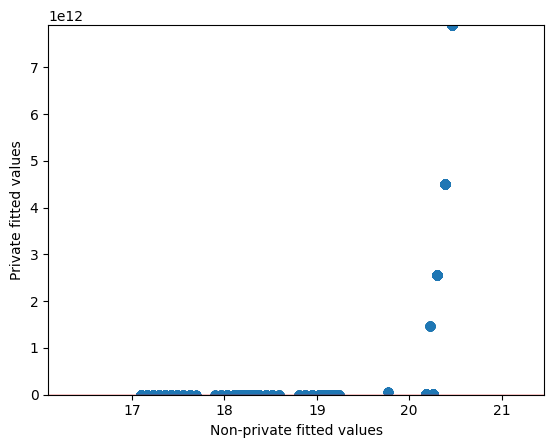

In [24]:


# fv= np.exp(np.matmul(mdt.exog,true_values[0:4])+RE+true_values[5]/2+true_values[4]/2)
fv= np.exp(np.matmul(mdt.exog,true_values[0:4])+true_values[5]/2+true_values[4]/2)

plt.scatter(fv,pfv3)
plt.axline((0, 0), (1, 1), linewidth=1, color='r')
plt.xlim((min(fv)-1,max(fv)+1))
plt.ylim((min(pfv3)-1,max(pfv3)+1))
plt.xlabel('Non-private fitted values')
plt.ylabel('Private fitted values')
plt.show()

Index(['weeks4', 'variable', 'value'], dtype='object')


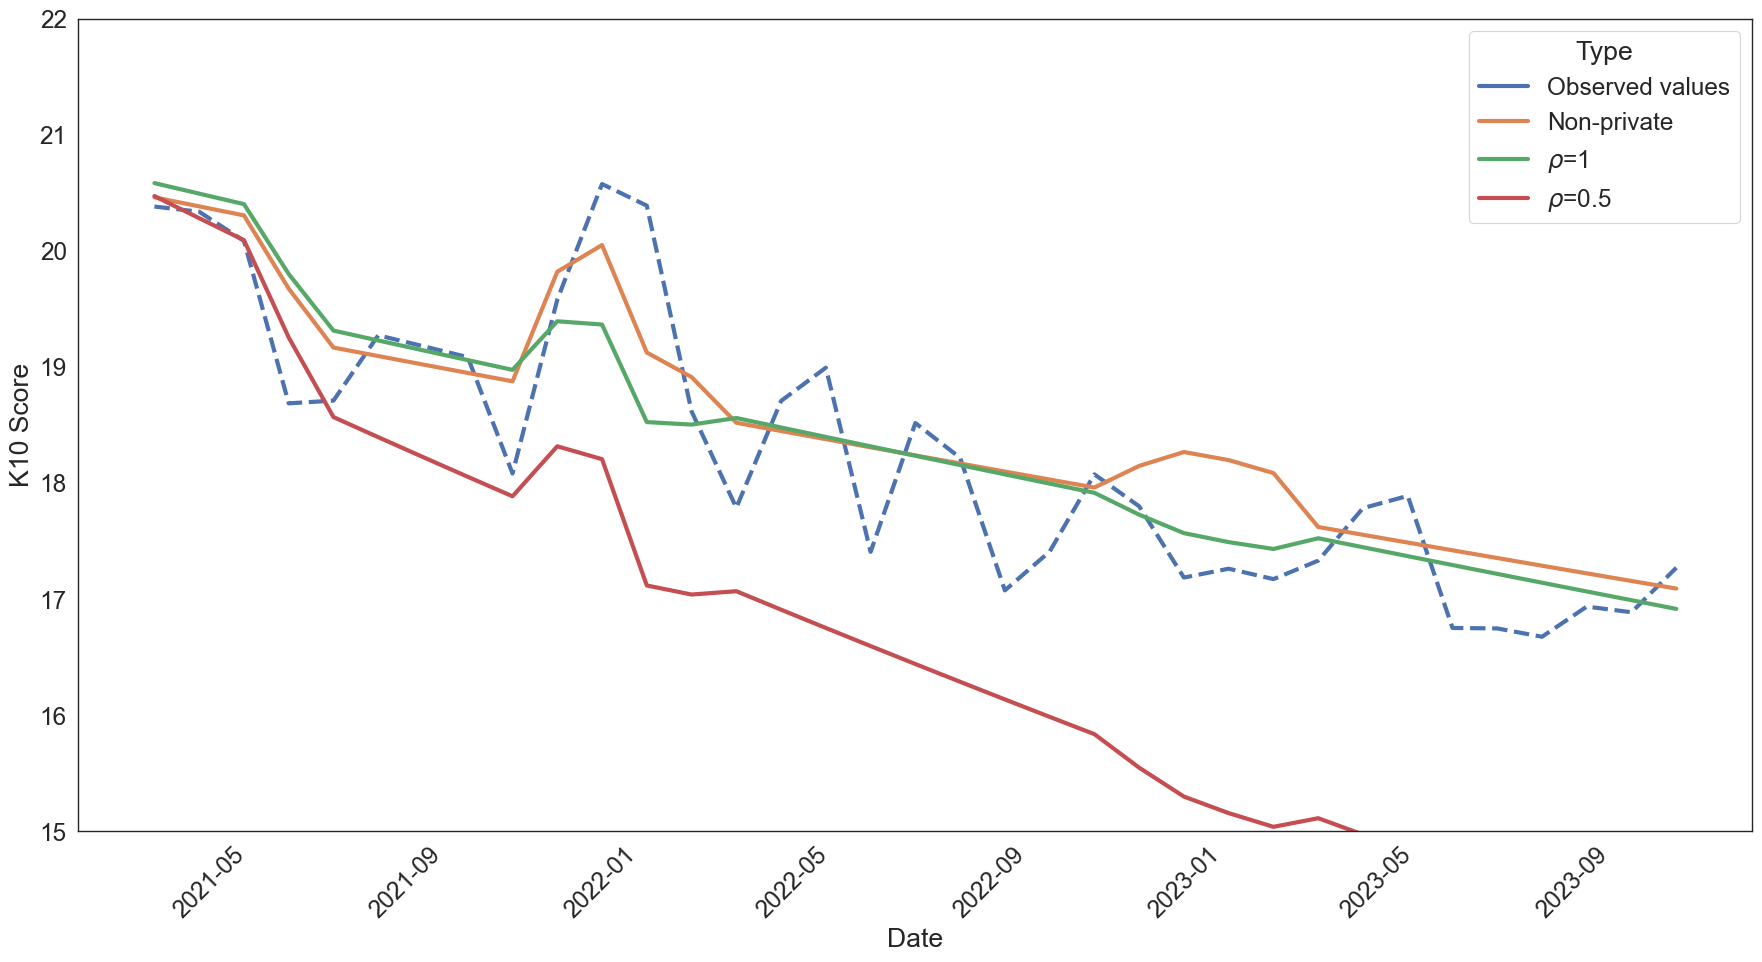

In [39]:
df2=df.copy()
df2['pfv1']=pfv1
df2['pfv2']=pfv2
df2['pfv3']=pfv3
df2['fv']=fv
df2['tv']=df['score']
# df_p=df2[['tv','fv','pfv1','pfv2','pfv3','weeks4']].groupby('weeks4').mean().reset_index()
df_p=df2[['tv','fv','pfv1','pfv2','weeks4']].groupby('weeks4').mean().reset_index()


# dfm=pd.melt(id_vars='weeks4',value_vars=['fv','pfv'])
# dfm=pd.melt(frame=df_p,id_vars='weeks4',value_vars=['tv','fv','pfv1','pfv2','pfv3'])
dfm=pd.melt(frame=df_p,id_vars='weeks4',value_vars=['tv','fv','pfv1','pfv2'])

print(dfm.columns)
dfm.columns=['Date', r'$\rho$', 'K10 Score']

new_names={'tv': 'Observed values', 'fv': r'$\infty$',
'pfv1': r'1',
'pfv2': r'0.5'
# ,
# 'pfv3': r'0.1',

}

new_names={'tv': 'Observed values', 'fv': r'Non-private',
'pfv1': r'$\rho$=1',
'pfv2': r'$\rho$=0.5'#,
# 'pfv3': r'$\rho$=0.1',

}

# dfm[r'$\rho$']=dfm[r'$\rho$'].map(new_names)
dfm['Type']=dfm[r'$\rho$'].map(new_names)
dfm["Date"]=pd.to_datetime(dfm["Date"])


sns.set(font_scale=5.0)
sns.set_theme(style='white',rc={'figure.figsize':(18,10)})
sns.set_context("paper", font_scale=2)
m=sns.lineplot(data=dfm,x='Date',y='K10 Score',hue='Type',linewidth = 3)

m.set_xticklabels(m.get_xticklabels(), rotation=45)
m.set_ylim((15,22))
m.lines[0].set_linestyle("--")
plt.tight_layout()
# m.lines[1].set_linestyle("--")
# m.lines[1].set_linestyle("--")
# m.lines[1].set_linestyle("--")
m
plt.savefig('LMM_Output.png', dpi=400)

In [24]:
# Then, we can plot the fitted values against the 
# fitted values of the nonprivate model where the random effects are 0

# Subsample and aggregate code
# set.seed()??
np.random.seed(seed=30) 
# size of groups
k=40


# split the data into k sub samples
ids=df['id'].unique()
np.random.shuffle(ids) 
id_groups=[ids[i:i+k] for i in range(0,len(ids)-k+1,k)]
dfs=[df[df['id'].isin(cid)] for cid in id_groups ]

all_ests=[]
for sdf in dfs:
    md = smf.mixedlm("lscore~time+winter+mitigation", sdf, groups=sdf["id"], re_formula="~1")
    try:
        mdf = md.fit(method=["lbfgs"])
        res=list(mdf.fe_params)+[mdf.cov_re.iloc[0,0],mdf.scale]
        all_ests.append(res)
    except:
        print("Singular!")
    # print(mdf.summary())
all_ests=[np.array(x) for x in all_ests]
all_est=np.vstack(all_ests)
all_ests=np.array(all_ests)
all_ests.shape


(58, 6)